In [1]:
import os
import PIL
import cv2
import scipy
import pathlib
import winsound
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm as notebook_tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline 

## Dataset
The textile fabric database consists of 245 images of 7 different fabrics. There are 140 defect-free images, 20 for each type of fabric. With different types of defects, there are 105 images.

Images have a size of 4096×256 pixels. Defective images have been denominated as follows: nnnn_ddd_ff.png, where nnnn is the image number, ddd is the defect code, and ff is the fabric code.

In [2]:
dataset_folder = "..\\archive"  
no_defect_images_folder = os.path.join(dataset_folder, "NODefect_images")
defect_images_folder = os.path.join(dataset_folder, "Defect_images")
mask_images_folder = os.path.join(dataset_folder, "Mask_images")

def gather_filenames(mypath: os.path) -> list[str]:
    filepaths = []
    for path, _, files in os.walk(mypath):
        for name in files:
            filepaths.append(os.path.join(path, name))
    return filepaths

defect_file_paths = gather_filenames(defect_images_folder)
no_defect_file_paths = gather_filenames(no_defect_images_folder)

print(f'Defects found: {len(defect_file_paths)}\nNo Defects found: {len(no_defect_file_paths)}')


Defects found: 106
No Defects found: 141


In [3]:
# Defect codes
DEFECT_CODES = {
    0:  'No defect',
    2:	'Broken end',
    6:	'Broken yarn',
    10:	'Broken pick',
    #16:	'Weft curling',
    #19:	'Fuzzyball',
    22: 'Cut selvage',
    23: 'Crease',
    25:	'Warp ball',
    #27: 'Knots',
    #29:  'Contamination',
    #30:  'Nep',
    #36:  'Weft crack'
}
output_len = len(DEFECT_CODES)

#encode defects to 0-12
DEFECT_ENCODINGS = {}
for i, key in zip(range(len(DEFECT_CODES)) , DEFECT_CODES.keys()):
    DEFECT_ENCODINGS[key] = i

def extract_labels(filepaths: list[str]) -> pd.DataFrame:
    file_df = pd.DataFrame(filepaths, columns=['filepath'])

    # x.split('\\') willl give the filename, then x.split('_') will give the labels
    file_df['id'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[0]))
    file_df['defect'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[1]))
    file_df['fabric'] = file_df['filepath'].map(lambda x: int(x.split('\\')[-1].split('_')[2].split('.')[0]))
    return file_df

In [4]:
# Files names to image dataset
defect_file_df = extract_labels(defect_file_paths)
no_defect_file_df = extract_labels(no_defect_file_paths)

# drop unwanted labels
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 16].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 19].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 27].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 29].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 30].index)
defect_file_df = defect_file_df.drop(defect_file_df[defect_file_df['defect'] == 36].index)

# Select Defects to encode
defect_file_df['defect'] = defect_file_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])
no_defect_file_df['defect'] = no_defect_file_df['defect'].map(lambda x: DEFECT_ENCODINGS[x])


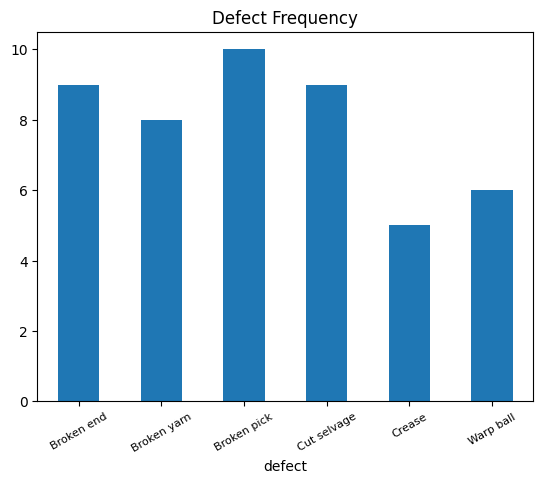

In [5]:
ax = defect_file_df['defect'].value_counts().sort_index().plot(kind = 'bar', title='Defect Frequency')
plt.xticks(range(0,len(DEFECT_CODES) - 1), list(DEFECT_CODES.values())[1:])
ax.xaxis.set_tick_params(rotation=30, labelsize=8)
plt.gca().spines[['top', 'right',]].set_visible(True)

In [6]:
def load_image(file_path: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=1)
    return image, label, file_path

def shuffle_split(file_ds):
    # shuffle
    ds_size = len(file_ds)
    file_ds = file_ds.shuffle(ds_size, seed=3, reshuffle_each_iteration=False)

    # split
    train_split = 0.80
    train_size = int(train_split * ds_size)

    val_split = 0.10
    val_size = int(val_split * ds_size)

    test_split = 0.10

    train_ds = file_ds.take(train_size)
    val_ds = file_ds.skip(train_size).take(val_size)
    test_ds = file_ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

# Files names to image dataset
full_file_df = pd.concat([defect_file_df, no_defect_file_df])

files_arr = full_file_df['filepath'].to_numpy()
labels_arr = full_file_df['defect'].to_numpy()

# Tf dataset
file_ds = tf.data.Dataset.from_tensor_slices((files_arr, labels_arr))
train_ds, val_ds, test_ds = shuffle_split(file_ds)

# load images
val_ds = val_ds.map(load_image)
test_ds = test_ds.map(load_image)
train_ds = train_ds.map(load_image)

# seperate no defect from defect
no_defect_train_image_ds = train_ds.filter(lambda _, label, path: label == 0)
defect_train_image_ds = train_ds.filter(lambda _, label, path: label > 0)

rng = tf.random.Generator.from_seed(123, alg='philox')

def augment(image, label, path, seed):
    # Make new seed
    new_seed = tf.random.split(seed, num=1)[0, :]
    # Random brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    # random vertical flip
    image = tf.image.stateless_random_flip_up_down(
        image, seed=new_seed)

    image = tf.clip_by_value(image, 0, 255)
    return image, label, path

def augment_update(x,y,z):
    seed = rng.make_seeds(1)[:, 0]
    x,y,z = augment(x, y, z, seed)
    return x,y,z

augments_per_image = 5
augmented_defects_ds = (
    defect_train_image_ds
    .repeat(augments_per_image)
    .map(lambda x, y, z: augment_update(x, y, z))
)

# print(f"Number of defects before augmentation: {len(list(defect_train_image_ds.as_numpy_iterator()))}\n")
defect_train_image_ds = defect_train_image_ds.concatenate(augmented_defects_ds)
# print(f"Number of defects after augmentation: {len(list(augmented_defects_ds.as_numpy_iterator()))}\n")
# print(f"Number of no-defects: {len(list(no_defect_train_image_ds.as_numpy_iterator()))}\n")
train_ds = defect_train_image_ds.concatenate(no_defect_train_image_ds)
# print(f"Number of total training images: {len(list(train_ds.as_numpy_iterator()))}")

In [7]:
def normalize(image, label, file_path):
    image = tf.cast(image, tf.float32)

    image -= tf.reduce_mean(image, axis=0)
    image = (image / 255.0)
    return image, label


val_ds = val_ds.map(lambda x,y,z: normalize(x,y,z))
test_ds = test_ds.map(lambda x,y,z: normalize(x,y,z))
train_ds = train_ds.map(lambda x,y,z: normalize(x,y,z))

In [8]:
def view_ds(ds):
    for i in ds:
        
        print(i)
    return 

view_ds(train_ds)

(<tf.Tensor: shape=(256, 4096, 1), dtype=float32, numpy=
array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.04397978],
        [-0.00654105],
        [ 0.02333027]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.05182292],
        [ 0.00130208],
        [-0.01196385]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.01260723],
        [ 0.02090993],
        [-0.02372855]],

       ...,

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.00084252],
        [ 0.06404718],
        [ 0.07038909]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.09327512],
        [ 0.04443934],
        [-0.01980698]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.06974571],
        [ 0.0365962 ],
        [-0.00412071]]], dtype=float3

In [9]:
a = np.array(list(train_ds.map(lambda x,y: x).unbatch().as_numpy_iterator()))
a = a.reshape((a.shape[0], a.shape[1]))
print(a.shape)

(84480, 4096)


In [26]:

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
print(X.shape)
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)


(6, 2)
[0.99244289 0.00755711]


In [38]:
pca = PCA(n_components=2)
pca.fit(a)
PCA(n_components=2)

PCA(n_components=2)

In [10]:
pca = PCA(0.99)
pca.fit(a)
PCA(copy = True, iterated_power = 'auto', n_components = 0.99, random_state = None, svd_solver = 'auto', tol = 0.0, whiten = True)
pca.n_components_

In [39]:
converted_data = pca.fit_transform(a)
converted_data

array([[-0.11103355, -0.00907917],
       [-0.09724637, -0.04116447],
       [-0.04088198,  0.02866393],
       ...,
       [ 0.26482138,  0.21318844],
       [ 0.03456644,  0.28691265],
       [-0.12413365,  0.23266622]], dtype=float32)

In [11]:
# Finding the Eigne Values and Vectors for the data
eigen_values, eigen_vectors = tf.linalg.eigh(tf.tensordot(tf.transpose(a), a, axes=1))
print(f"Eigen Vectors: \n{eigen_vectors} \nEigen Values: \n{eigen_values}".format(eigen_vectors, eigen_values))

ResourceExhaustedError: {{function_node __wrapped____MklMatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[3145728,3145728] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:MatMul] name: 

In [ ]:
# PCA
x_data = tf.multiply(5, tf.random.uniform([100], minval=0, maxval=100, dtype = tf.float32, seed = 0))
y_data = tf.multiply(2, x_data) + 1 + tf.random.uniform([100], minval=0, maxval=100, dtype = tf.float32, seed = 0)
X = tf.data.Dataset.from_tensor_slices((x_data, y_data))

def normalize(data, label):
    # creates a copy of data
    X = tf.identity(data)
    # calculates the mean
    X -=tf.reduce_mean(data, axis=0)
    return X, label
normalized_data = X.map(normalize)


In [ ]:
# Finding the Eigne Values and Vectors for the data
eigen_values, eigen_vectors = tf.linalg.eigh(tf.tensordot(tf.transpose(a), a, axes=1))
print(f"Eigen Vectors: \n{eigen_vectors} \nEigen Values: \n{eigen_values}".format(eigen_vectors, eigen_values))

: 

In [ ]:
enc = OneHotEncoder()
enc.fit([[i] for i in list(range(len(DEFECT_CODES)))])

spec = tf.TensorSpec(shape=[len(DEFECT_CODES),], dtype=tf.int64)
@tf.py_function(Tout=spec)
def map_defect_to_one_hot(tensor):
    tensor = enc.transform(
        tensor.numpy().reshape(1, 1)
        ).toarray()[0]
    return tensor

#preprocess images
def preprocess_img(image: tf.Tensor, label: tf.Tensor, file_path: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    image = tf.cast(image, tf.uint8)
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image, [224, 224])
    # one hot encode the defects
    label = map_defect_to_one_hot(label)
    return image, label

# augmented_defects_ds = augmented_defects_ds.map(lambda x,y,z: preprocess_img(x,y,z))

val_ds = val_ds.map(lambda x,y,z: preprocess_img(x,y,z))
test_ds = test_ds.map(lambda x,y,z: preprocess_img(x,y,z))
train_ds = train_ds.map(lambda x,y,z: preprocess_img(x,y,z))

In [ ]:
def display_tensor_as_image(tensor: tf.Tensor):
    print(tensor.shape)
    plt.gray()
    plt.imshow(tensor.numpy())
    plt.show()

In [ ]:
X

In [ ]:
# len(train_ds) = 185
val_ds = val_ds.batch(4, drop_remainder=True)
test_ds = test_ds.batch(4, drop_remainder=True)
train_ds = train_ds.batch(4, drop_remainder=True)

In [ ]:

a,b = view_ds(train_ds)
print(a,b)

def set_shapes(image, label):
    image.set_shape(a)
    label.set_shape(b)
    return image, label

train_ds = train_ds.map(set_shapes)
val_ds = val_ds.map(set_shapes)
# test_ds = test_ds.map(set_shapes)

num_batches = len(list(train_ds.as_numpy_iterator()))
# print(len(list(val_ds.as_numpy_iterator())))
# print(len(list(test_ds.as_numpy_iterator())))

train_ds = train_ds.apply(tf.data.experimental.assert_cardinality(num_batches))
print(len(train_ds)) # NUM_BATCHES


In [ ]:
train_ds.element_spec

## Supervised Learning

In [ ]:
# Transfer learning on the top layers
# Load convolutional weights that are trained on ImageNet data

base_model = tf.keras.applications.resnet.ResNet152(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (224, 224, 3)
)

# Freeze pretrained layers
for layer in base_model.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
predictions = tf.keras.layers.Dense(output_len, activation = 'softmax')(x)

head_model = tf.keras.Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss= tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history = head_model.fit(train_ds, epochs= 5, validation_data= val_ds)

duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
# test_ds = test_ds.concatenate(val_ds)

head_model.evaluate(test_ds, verbose=2)

In [ ]:
metric = tf.keras.metrics.F1Score()

test_y_true_ds = [label.numpy() for _, label in test_ds.unbatch()]
test_y_true_ds = np.array(test_y_true_ds)
test_y_pred_ds = head_model.predict(test_ds, verbose=2)

metric.update_state(test_y_true_ds, test_y_pred_ds)
result = metric.result()
result.numpy()


In [ ]:
true_labels = np.array([np.argmax(label) for label in test_y_true_ds])
pred_labels = np.array([np.argmax(label) for label in test_y_pred_ds])
tf.math.confusion_matrix(true_labels, pred_labels)

Model Deployment/Evaluation

Unsupervised or Semisupervised Learning